In [52]:
%matplotlib inline
# %load_ext lab_black

nb_samples = 64
list_features = ["longitude", "latitude"] #, "track"] #, "altitude"]
nb_features = len(list_features)

In [2]:
%load_ext autoreload
%autoreload 2

In [53]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
# from traffic.data.datasets import landing_zurich_2019 as t
from traffic.algorithms.clustering import prepare_features
import pandas as pd
from traffic.core import Traffic
pd.set_option("display.max_columns", None)

df = pd.read_parquet("/Users/arthur.laquieze/Dev/adsb-traffic-indicators/data/from_lszh/resampled_t_near_ap.parquet")

t = Traffic(df)



In [51]:
from traffic.core import Flight

def interpolate_track(flight: Flight) -> Flight:
    """
    Interpolate the ground speed and altitude columns to fill the missing values
    """

    flight.data["track"] = flight.data["track"].interpolate(method="linear", limit_direction="both")

    return flight

t = t.pipe(interpolate_track).eval()

t.data["track"].isna().sum()

2048

In [54]:
t.data.columns

Index(['timestamp', 'estimated_arrival_time_utc', 'scheduled_arrival_time_utc',
       'scheduled_departure_time_utc', 'icao24', 'latitude', 'longitude',
       'collection_type', 'altitude', 'groundspeed', 'track', 'callsign',
       'source', 'onground', 'vertical_rate', 'squawk', 'icao_actype',
       'number', 'origin', 'destination', 'tail_number', 'ingestion_time',
       'flight_id', 'distance', 'track_unwrapped'],
      dtype='object')

In [ ]:
# t_f = (
#     t.query("track == track").resample(nb_samples).unwrap("track").eval(max_workers=10)
# )
# #t_f = t.query("track == track and initial_flow == '162-216' and runway =='14'").resample(30).unwrap("track").eval(max_workers=10)
# #t_f = t.query("track == track and initial_flow in ['162-216', '90-132'] and runway in ['14', '28']").unwrap("track").resample(30).eval(max_workers=10)

# t_f.to_parquet("data/lszh.parquet")
# X = prepare_features(t_f, None, list_features)
# X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
# np.save("data/lszh.npy", X)

In [55]:
t

,count
flight_id,
AAL93_7715,64
SWR2696_5931,64
SWR272P_2781,64
SWR272P_2780,64
SWR272P_2136,64
SWR272P_1790,64
SWR272P_1789,64
SWR272P_1645,64
SWR2696_5630,64


In [59]:
t_f = Traffic(t.data.copy())  # (
    # t.query("track == track").resample(nb_samples).unwrap("track").eval(max_workers=10)
# )


#t_f = t.query("track == track and initial_flow == '162-216' and runway =='14'").resample(30).unwrap("track").eval(max_workers=10)
#t_f = t.query("track == track and initial_flow in ['162-216', '90-132'] and runway in ['14', '28']").unwrap("track").resample(30).eval(max_workers=10)

t_f.to_parquet("data/lszh_onground.parquet")
X = prepare_features(t_f, None, list_features)
X = MinMaxScaler(feature_range=(-1, 1)).fit_transform(X)
np.save("data/lszh_onground.npy", X)

In [64]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from traffic.core import Traffic
from artefact import Autoencoder
from artefact.clustering import get_latent
from artefact.training import train
from artefact.plot import plot_loss, plot_latent, plot_latent_and_trajs

t = Traffic.from_file("data/lszh_onground.parquet")
X = np.load("data/lszh_onground.npy")
model_ = Autoencoder((nb_samples * nb_features, 32, 8, 2))
device = "cpu"

encoder Sequential(
  (0): Linear(in_features=128, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=2, bias=True)
  (5): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=128, bias=True)
  (5): Sigmoid()
)


In [58]:
t.data["track"].isna().sum()

11345

In [18]:
torch.backends.mps.is_available()

True

In [65]:
device = "cpu"
model, loss = train(
    model_, X, device=device, nb_iterations=10000, batch_size=len(X), lambda_kl=0
)
# model, loss = train(
#     model_, X, device=device, nb_iterations=10000, batch_size=len(X), lambda_kl=0
# )


batches:   0%|          | 0/1 [00:00<?, ?batch/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

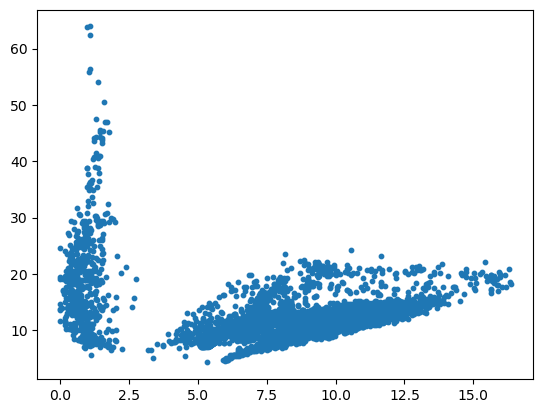

In [66]:
torch.save(model.state_dict(), "models/onground_10000.pth")
plot_latent(X, model, device)

In [21]:
model = model_
model.load_state_dict(torch.load("models/onground_10000.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_ae.png", runway=14)

UndefinedVariableError: name 'runway' is not defined

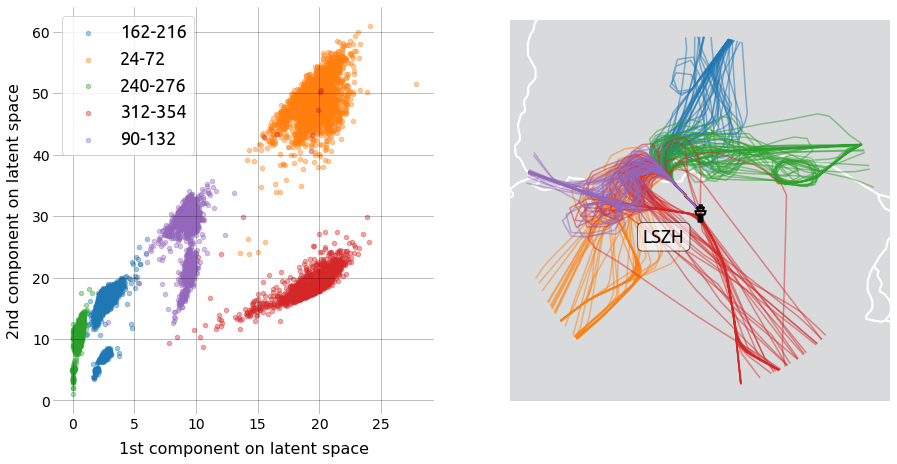

In [4]:
model.load_state_dict(torch.load("models/ae_10000.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_ae.png", runway=14)

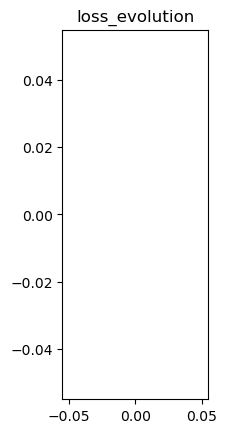

In [22]:
plot_loss(loss["loss"])

batches:   0%|          | 0/20 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

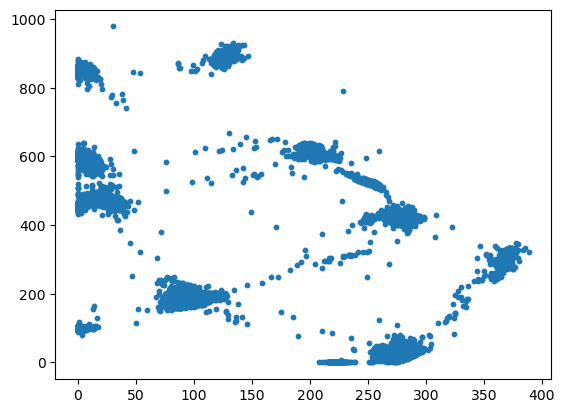

In [11]:
device = "cpu"
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.05
)
torch.save(model.state_dict(), "models/tsne_500_005.pth")
plot_latent(X, model, device)

findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not found.
findfont: Font family 'Ubuntu' not

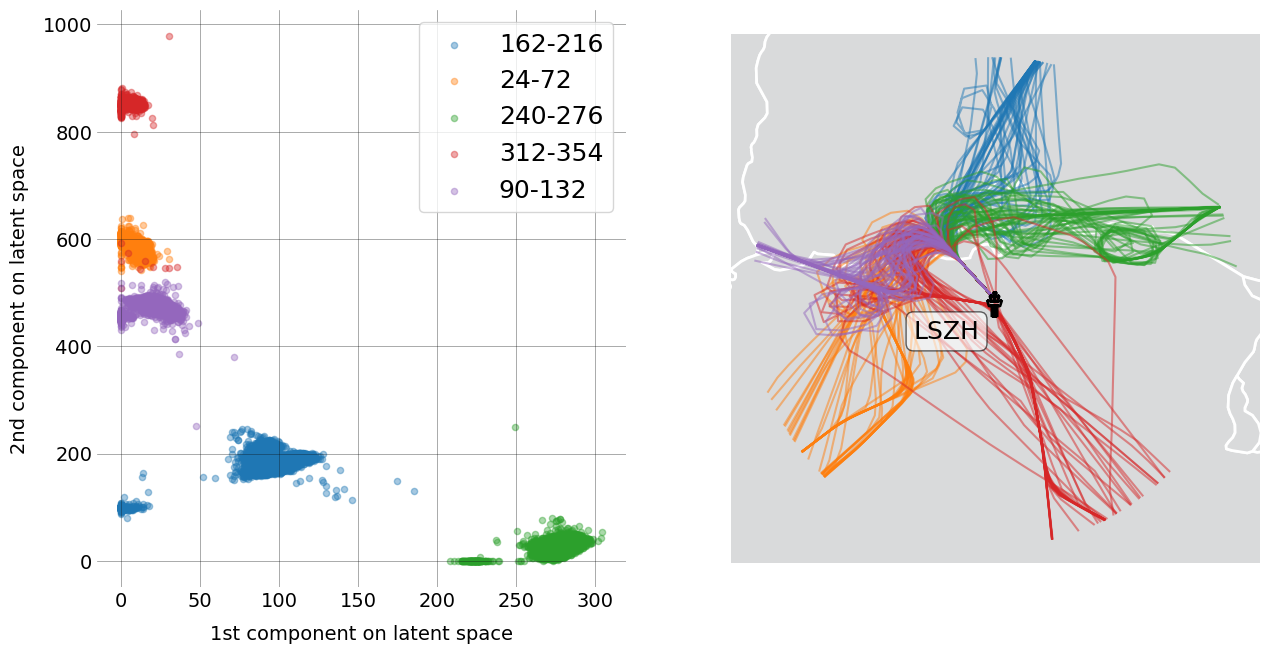

In [12]:
model.load_state_dict(torch.load("models/tsne_500_005.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_tsne_500_005.png", runway=14)

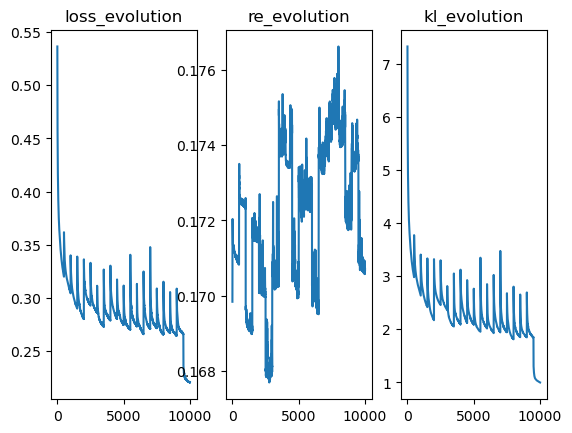

In [13]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

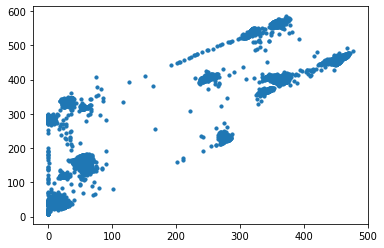

In [9]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.01
)
torch.save(model.state_dict(), "models/tsne_500_001.pth")
plot_latent(X, model, device)

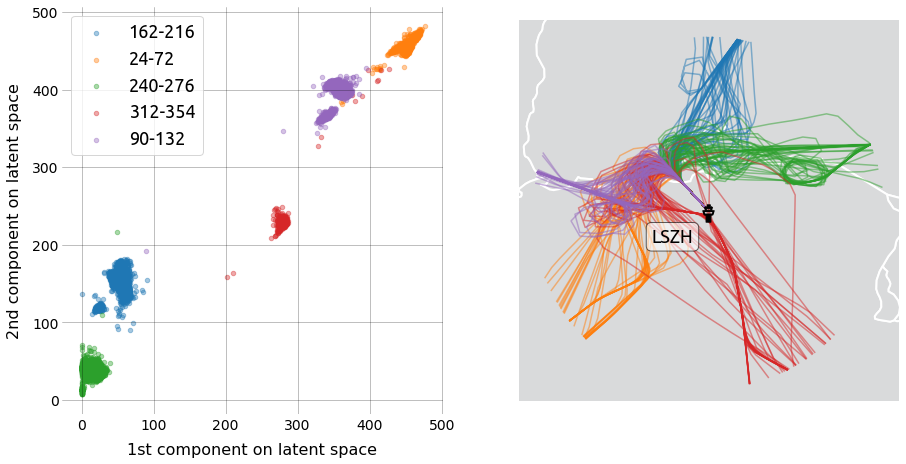

In [10]:
model.load_state_dict(torch.load("models/tsne_500_001.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_tsne_500_001.png", runway=14)

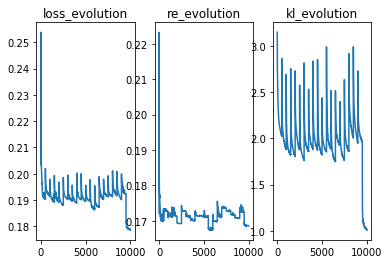

In [11]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

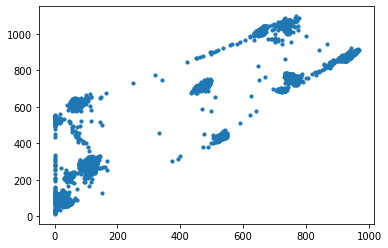

In [12]:
model, loss = train(
    model_, X, device=device, nb_iterations=500, batch_size=1000, lambda_kl=0.07
)
torch.save(model.state_dict(), "models/tsne_500_007.pth")
plot_latent(X, model, device)

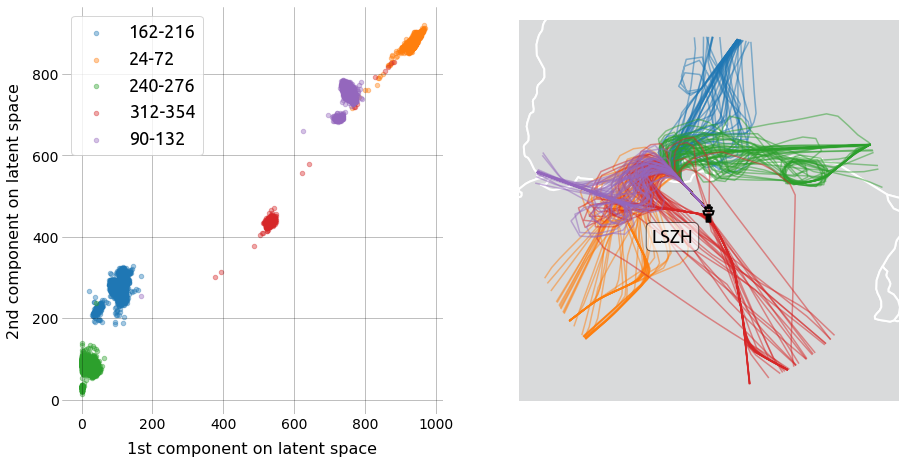

In [13]:
model.load_state_dict(torch.load("models/tsne_500_007.pth"))
lat = get_latent(X, model, device)
plot_latent_and_trajs(t, lat, "figs/latent_tsne.png", runway=14)

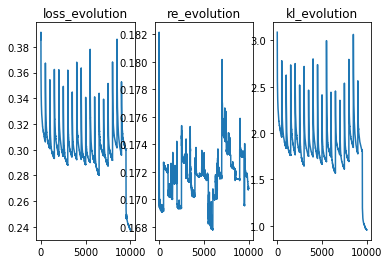

In [14]:
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

In [108]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import MinMaxScaler

from traffic.core import Traffic

from artefact import AutoencoderTSNE, Autoencoder

t = Traffic.from_file("data/lszh_onground.parquet")
# list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
# list_features = ["track_unwrapped", "longitude", "latitude", ]
list_features = ["longitude", "latitude"]

nb_flights = len(t)
nb_samples = len(t[0])
nb_features = len(list_features)
lambda_kl = 0.07
print(f"nb_flights: {len(t)}")

device = "cpu"

algo_clustering = AutoencoderTSNE(
    gpu=device,
    batch_size=1000,
    model=Autoencoder((nb_samples * nb_features, 32, 8, 2)),
    lambda_kl=lambda_kl,
    nb_iterations=500,
    # algo_clustering=DBSCAN(eps=0.05, min_samples=20),
    algo_clustering=DBSCAN(eps=0.5, min_samples=10),
    distance_trajectory="euclidean",  # delta_max
    # savedir=".",
    savepath="./models_tsne/onground_500_007.pth",
)
model = algo_clustering.model

t_tsne = t.clustering(
    nb_samples=None,
    features=list_features,
    clustering=algo_clustering,
    transform=MinMaxScaler(feature_range=(-1, 1)),
).fit_predict()

t_tsne.to_pickle("test/t_tsne.pkl")
t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"})

nb_flights: 4445
encoder Sequential(
  (0): Linear(in_features=128, out_features=32, bias=True)
  (1): ReLU()
  (2): Linear(in_features=32, out_features=8, bias=True)
  (3): ReLU()
  (4): Linear(in_features=8, out_features=2, bias=True)
  (5): ReLU()
)
decoder Sequential(
  (0): Linear(in_features=2, out_features=8, bias=True)
  (1): ReLU()
  (2): Linear(in_features=8, out_features=32, bias=True)
  (3): ReLU()
  (4): Linear(in_features=32, out_features=128, bias=True)
  (5): Sigmoid()
)


batches:   0%|          | 0/5 [00:00<?, ?batch/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/500 [00:00<?, ?it/s]

,flight_id
cluster,
-1,116
0,487
1,323
2,274
3,3208
4,13
5,12
6,12


In [88]:
t_tsne.data

,timestamp,estimated_arrival_time_utc,scheduled_arrival_time_utc,scheduled_departure_time_utc,icao24,latitude,longitude,collection_type,altitude,groundspeed,track,callsign,source,onground,vertical_rate,squawk,icao_actype,number,origin,destination,tail_number,ingestion_time,flight_id,distance,track_unwrapped,cluster
0,2022-01-04 09:47:56+00:00,2022-01-04 19:02:00+00:00,2022-01-04 19:10:00+00:00,2022-01-04 09:50:00+00:00,AAF828,47.462505,8.555431,terrestrial,1675.000000,1.9,NaN,AAL93,None,True,NaN,NaN,B788,AA93,LSZH,KPHL,N806AA,2022-01-04 09:48:01.382 UTC,AAL93_7725,0.401856,NaN,-1
1,2022-01-04 09:48:05+00:00,2022-01-04 19:02:00+00:00,2022-01-04 19:10:00+00:00,2022-01-04 09:50:00+00:00,AAF828,47.462540,8.555311,terrestrial,1675.000000,1.6,NaN,AAL93,None,True,NaN,NaN,B788,AA93,LSZH,KPHL,N806AA,2022-01-04 09:48:10.001 UTC,AAL93_7725,0.399631,NaN,-1
2,2022-01-04 09:48:16+00:00,2022-01-04 19:02:00+00:00,2022-01-04 19:10:00+00:00,2022-01-04 09:50:00+00:00,AAF828,47.462555,8.555251,terrestrial,1675.000000,0.1,NaN,AAL93,None,True,NaN,NaN,B788,AA93,LSZH,KPHL,N806AA,2022-01-04 09:48:19.565 UTC,AAL93_7725,0.398439,NaN,-1
3,2022-01-04 09:48:25+00:00,2022-01-04 19:02:00+00:00,2022-01-04 19:10:00+00:00,2022-01-04 09:50:00+00:00,AAF828,47.462555,8.555251,terrestrial,1675.000000,0.0,NaN,AAL93,None,True,NaN,NaN,B788,AA93,LSZH,KPHL,N806AA,2022-01-04 09:48:29.92 UTC,AAL93_7725,0.398439,NaN,-1
4,2022-01-04 09:48:29+00:00,2022-01-04 19:02:00+00:00,2022-01-04 19:10:00+00:00,2022-01-04 09:50:00+00:00,AAF828,47.462555,8.555251,terrestrial,1675.000000,0.1,NaN,AAL93,None,True,NaN,NaN,B788,AA93,LSZH,KPHL,N806AA,2022-01-04 09:48:34.015 UTC,AAL93_7725,0.398439,NaN,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284475,2022-01-03 09:15:53+00:00,2022-01-03 11:50:00+00:00,2022-01-03 11:40:00+00:00,2022-01-03 09:00:00+00:00,3430CC,47.456383,8.570229,terrestrial,1194.583333,7.2,90.0,VLG98LY,None,True,NaN,3067.0,A320,VY2171,LSZH,LEMG,EC-KLT,2022-01-03 13:18:58.57 UTC,VLG98LY_131,0.908350,90.0,-1
284476,2022-01-03 09:15:58+00:00,2022-01-03 11:50:00+00:00,2022-01-03 11:40:00+00:00,2022-01-03 09:00:00+00:00,3430CC,47.456515,8.570234,terrestrial,1196.250000,4.8,90.0,VLG98LY,None,True,NaN,3067.0,A320,VY2171,LSZH,LEMG,EC-KLT,2022-01-03 13:18:58.759 UTC,VLG98LY_131,0.907709,90.0,-1
284477,2022-01-03 09:16:03+00:00,2022-01-03 11:50:00+00:00,2022-01-03 11:40:00+00:00,2022-01-03 09:00:00+00:00,3430CC,47.456635,8.570211,terrestrial,1197.916667,4.2,90.0,VLG98LY,None,True,NaN,3067.0,A320,VY2171,LSZH,LEMG,EC-KLT,2022-01-03 13:19:27.223 UTC,VLG98LY_131,0.906070,90.0,-1
284478,2022-01-03 09:16:10+00:00,2022-01-03 11:50:00+00:00,2022-01-03 11:40:00+00:00,2022-01-03 09:00:00+00:00,3430CC,47.456703,8.570074,terrestrial,1198.750000,4.2,90.0,VLG98LY,None,True,NaN,3067.0,A320,VY2171,LSZH,LEMG,EC-KLT,2022-01-03 13:19:27.589 UTC,VLG98LY_131,0.900139,90.0,-1


In [112]:
algo_clustering.get_latent().shape

(4445, 2)

In [113]:
algo_clustering.X.shape

(4445, 128)

In [93]:
t.flight_ids.__len__()

4445

In [109]:
clusters = []
for _, id in zip(algo_clustering.X, t.flight_ids):
    cluster = t_tsne.data.loc[t_tsne.data["flight_id"] == id, "cluster"].values[0]
    clusters.append(cluster)

In [115]:
clusters = np.array(clusters)
clusters

array([0, 0, 1, ..., 3, 3, 3])

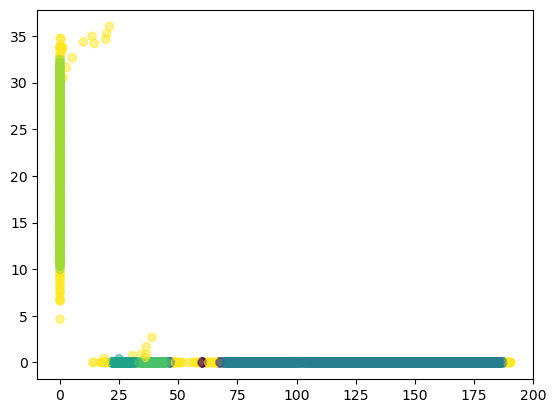

In [126]:
plt.scatter(algo_clustering.get_latent()[:, 0] , algo_clustering.get_latent()[:, 1], c=clusters*-1, alpha=0.5)

In [116]:
t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"})

,flight_id
cluster,
-1,116
0,487
1,323
2,274
3,3208
4,13
5,12
6,12


In [114]:
import cartopy.crs as ccrs
TRANSFORM = ccrs.PlateCarree()


In [117]:

import matplotlib.pyplot as plt

values = [-1, 0, 1, 2, 3, 4, 5, 6]
colors = plt.cm.rainbow([i/len(values) for i in range(len(values))])

color_map = dict(zip(values, colors))

print(color_map)


{-1: array([0.5, 0. , 1. , 1. ]), 0: array([0.24901961, 0.38410575, 0.98063477, 1.        ]), 1: array([0.00196078, 0.70928131, 0.92328911, 1.        ]), 2: array([0.25294118, 0.92563766, 0.83018403, 1.        ]), 3: array([0.50392157, 0.99998103, 0.70492555, 1.        ]), 4: array([0.75490196, 0.92090552, 0.55236497, 1.        ]), 5: array([1.        , 0.70054304, 0.37841105, 1.        ]), 6: array([1.        , 0.37270199, 0.18980109, 1.        ])}


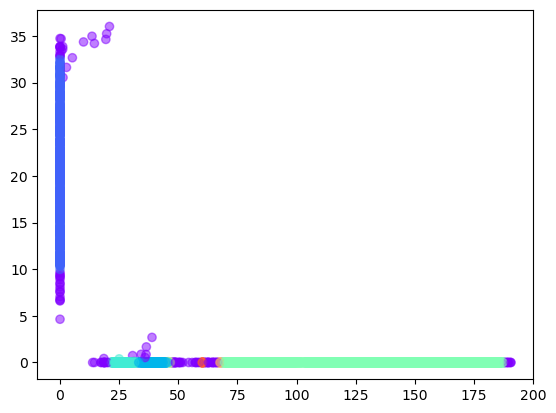

In [127]:
colors = [color_map[c] for c in clusters]

plt.scatter(algo_clustering.get_latent()[:, 0] , algo_clustering.get_latent()[:, 1], c=colors, alpha=0.5)

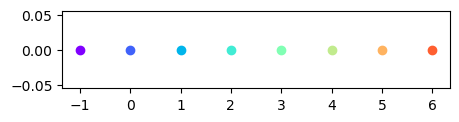

In [140]:
# show each cluster color
fig, ax = plt.subplots(figsize=(5, 1))

for cluster, color in color_map.items():
    plt.scatter(cluster, 0, c=color, label=cluster)

# plt.legend()

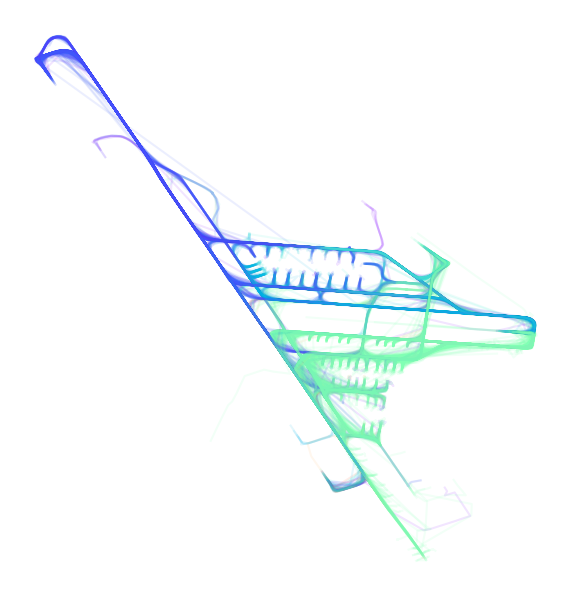

In [124]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 7.5))
    ax = fig.add_subplot(111, projection=TRANSFORM)

    for flight in t_tsne:
        cluster = flight.data.cluster.unique()[0]
        flight.plot(ax=ax, color=color_map[cluster], transform=TRANSFORM, alpha=0.1, label=cluster)

    # fig.legend()

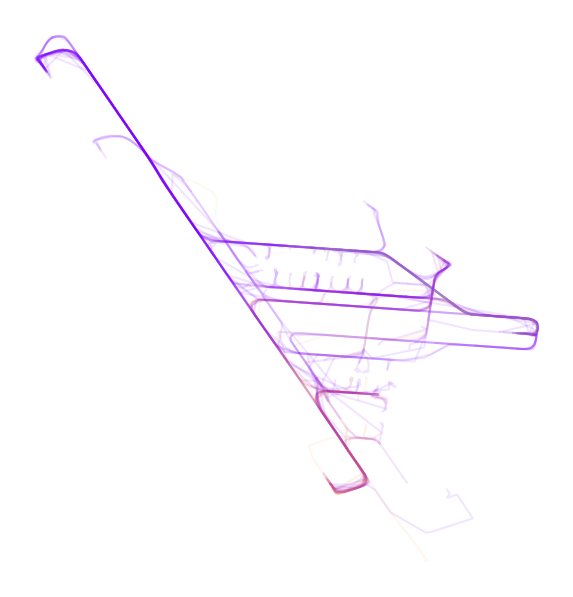

In [129]:
with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 7.5))
    ax = fig.add_subplot(111, projection=TRANSFORM)

    for flight in t_tsne:
        cluster = flight.data.cluster.unique()[0]
        if cluster <= 3 and cluster != -1:
            continue
        flight.plot(ax=ax, color=color_map[cluster], transform=TRANSFORM, alpha=0.1, label=cluster)

    # fig.legend()

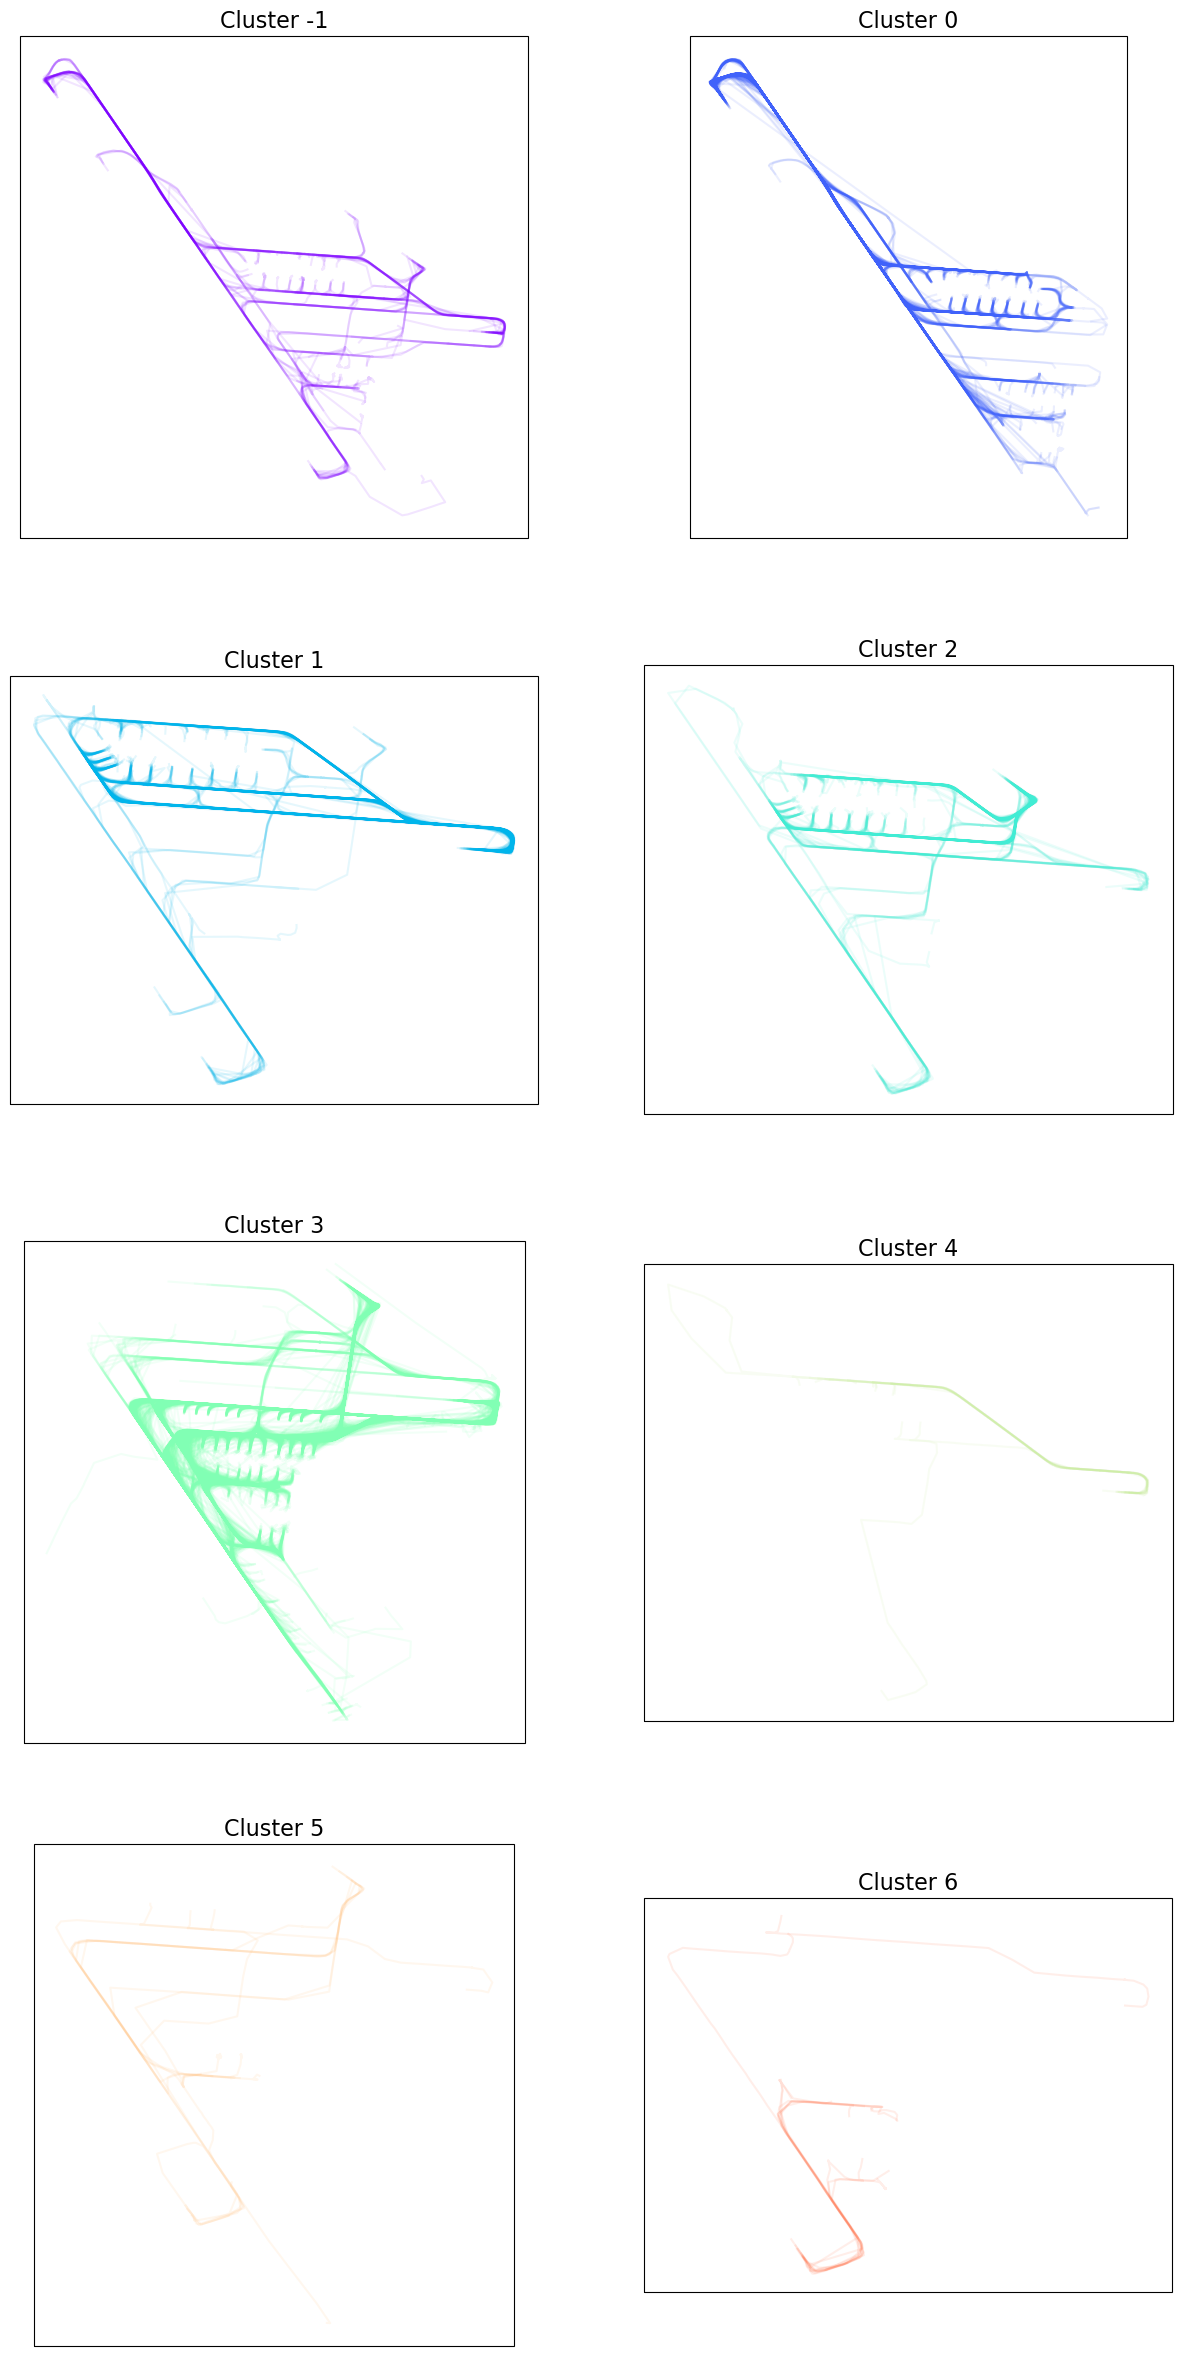

In [138]:
# 2 x 4 grid
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 30), subplot_kw={"projection": TRANSFORM})


for idx, cluster in enumerate(sorted(t_tsne.data.cluster.unique())):
    ids = t_tsne.query(f"cluster == {cluster}").data.flight_id.unique()

    with plt.style.context("traffic"):
        # ax = fig.add_subplot(111, projection=TRANSFORM)
        # ax = fig.add_subplot(111, projection=TRANSFORM)
        ax = axs[idx // 2, idx % 2]
        for flight in t_tsne[ids]:
            # flight.plot(ax=ax, color=color_map[cluster], transform=TRANSFORM, alpha=0.1, label=cluster)
            flight.plot(ax=ax, color=color_map[cluster], alpha=0.1, label=cluster)
        ax.set_title(f"Cluster {cluster}")
plt.show()

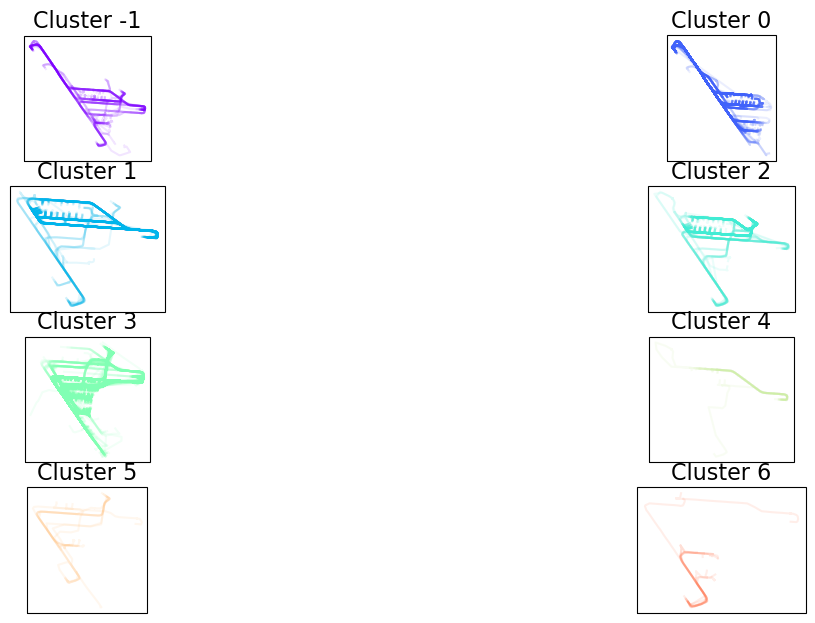

In [135]:
# 2 x 4 grid
fig, axs = plt.subplots(ncols=2, nrows=4, figsize=(15, 7.5), subplot_kw={"projection": TRANSFORM})


for idx, cluster in enumerate(sorted(t_tsne.data.cluster.unique())):
    ids = t_tsne.query(f"cluster == {cluster}").data.flight_id.unique()

    with plt.style.context("traffic"):
        # ax = fig.add_subplot(111, projection=TRANSFORM)
        # ax = fig.add_subplot(111, projection=TRANSFORM)
        ax = axs[idx // 2, idx % 2]
        for flight in t_tsne[ids]:
            flight.plot(ax=ax, color=color_map[cluster], transform=TRANSFORM, alpha=0.1, label=cluster)
            # flight.plot(ax=ax, color=color_map[cluster], alpha=0.1, label=cluster)
        ax.set_title(f"Cluster {cluster}")
plt.show()

In [77]:
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(t, algo_clustering.get_latent(), "figs/latent.png", runway=14)

UndefinedVariableError: name 'runway' is not defined

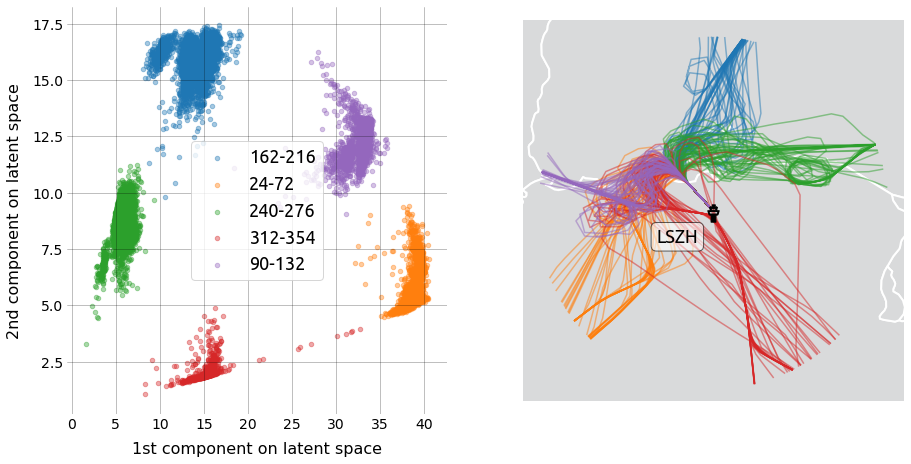

In [16]:
from artefact.plot import plot_latent_and_trajs

plot_latent_and_trajs(t, algo_clustering.get_latent(), "figs/latent.png", runway=14)

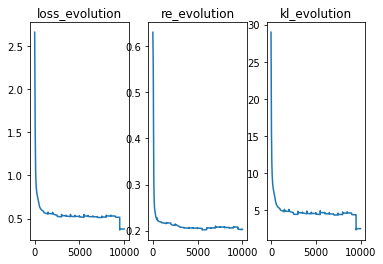

In [17]:
from artefact.plot import plot_loss

loss = algo_clustering.loss
plot_loss(loss["loss"], loss["re_loss"], loss["kl_loss"])

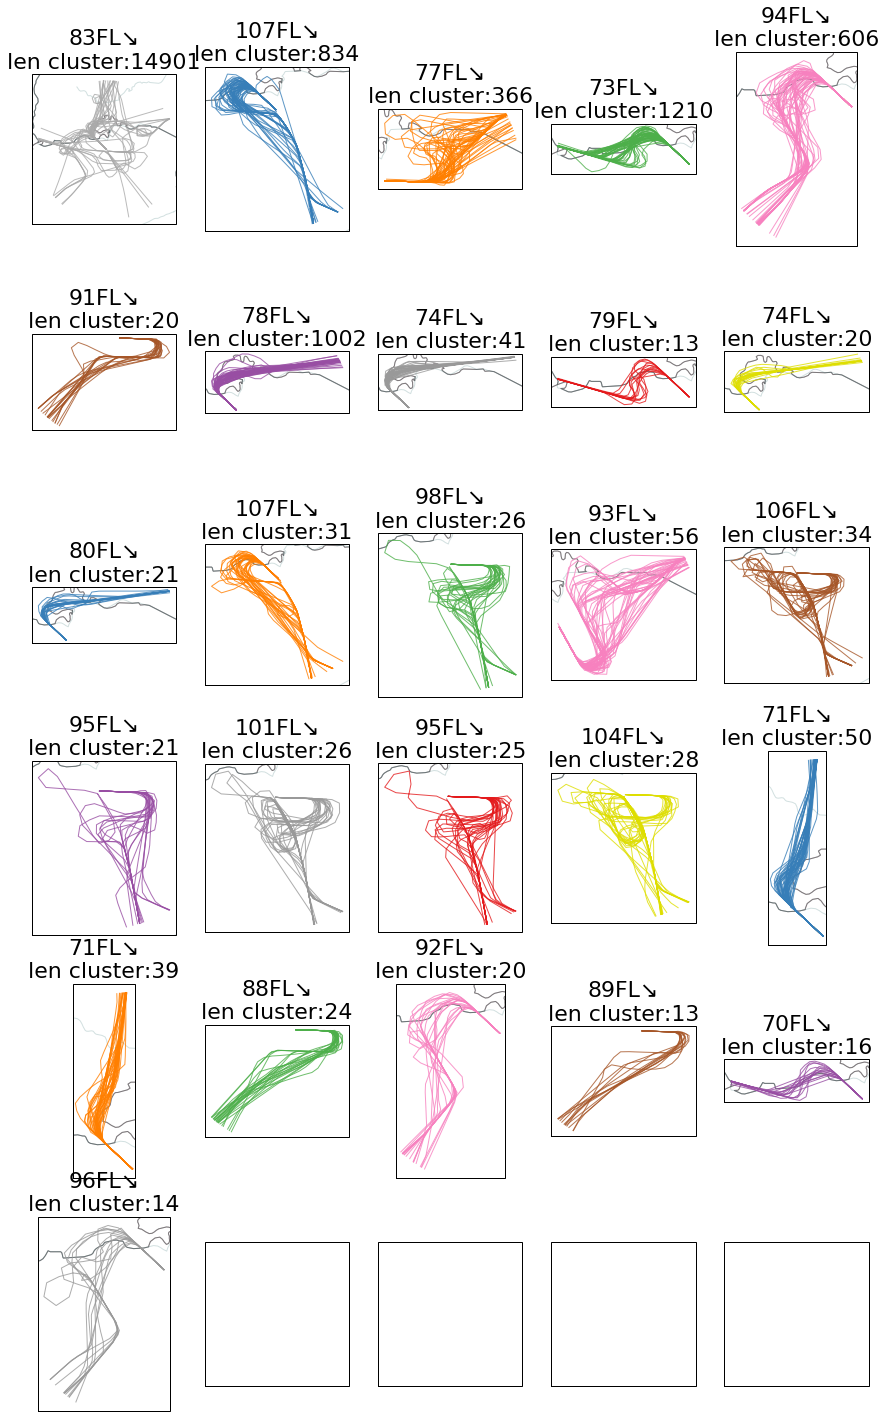

In [18]:
from traffic.core import Traffic
from artefact.plot import plot_trajs

t_tsne = Traffic.from_file("test/t_tsne.pkl")
plot_trajs(t_tsne, None)

In [13]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import DBSCAN
from sklearn.mixture import GaussianMixture
from traffic.core import Traffic
from artefact import AutoencoderTSNE, Autoencoder

def pretrained_clust(algo_clustering, pretrained_path, to_pickle):
    t = Traffic.from_file("data/lszh.parquet")
    list_features = ["track_unwrapped", "longitude", "latitude", "altitude"]
    nb_samples = len(t[0])
    nb_features = len(list_features)

    algo_clustering = AutoencoderTSNE(
        gpu=1,
        model=Autoencoder((nb_samples * nb_features, 32, 8, 2)),
        pretrained_path=pretrained_path,        
        algo_clustering=algo_clustering,
    )

    # X = np.load("data/lszh.npy")
    # algo_clustering.fit(X)
    t_tsne = t.clustering(
        nb_samples=None,
        features=list_features,
        clustering=algo_clustering,
        transform=MinMaxScaler(feature_range=(-1, 1)),
    ).fit_predict()

    t_tsne.to_pickle(to_pickle)
    print(t_tsne.groupby(["cluster"]).agg({"flight_id": "nunique"}))
    return t_tsne

         flight_id
cluster           
-1             468
 0            1734
 1            2037
 2            1275
 3             990
 4            3118
 5            4434
 6            1139
 7             728
 8            3491
 9              43


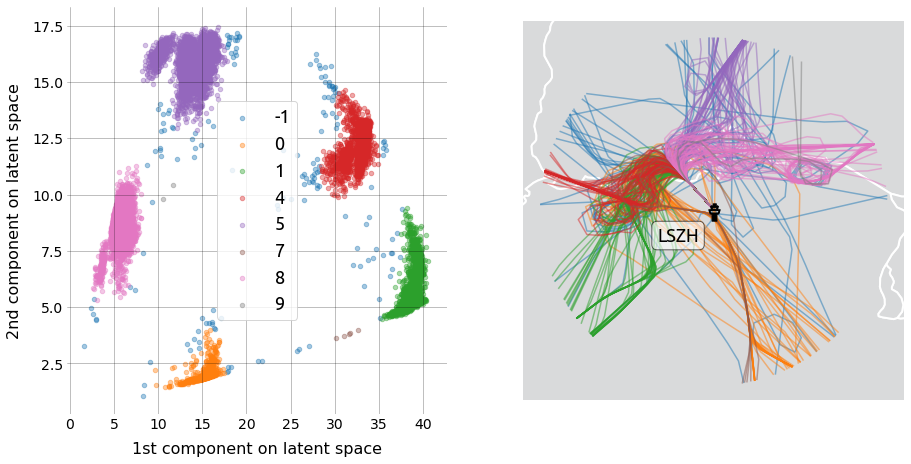

In [20]:
t_tsne = pretrained_clust(DBSCAN(eps=0.7, min_samples=30), "models/model.pth", "test/t_tsne_dbscan.pkl")
from artefact.plot import plot_latent_and_trajs
plot_latent_and_trajs(t_tsne, algo_clustering.get_latent(), "figs/latent_clusters_dbscan_07_30.png", plot_clusters=True, runway=14)

         flight_id
cluster           
-1             631
 0            1726
 1            2032
 2            1266
 3             966
 4            3086
 5            4422
 6            1125
 7             725
 8            3478


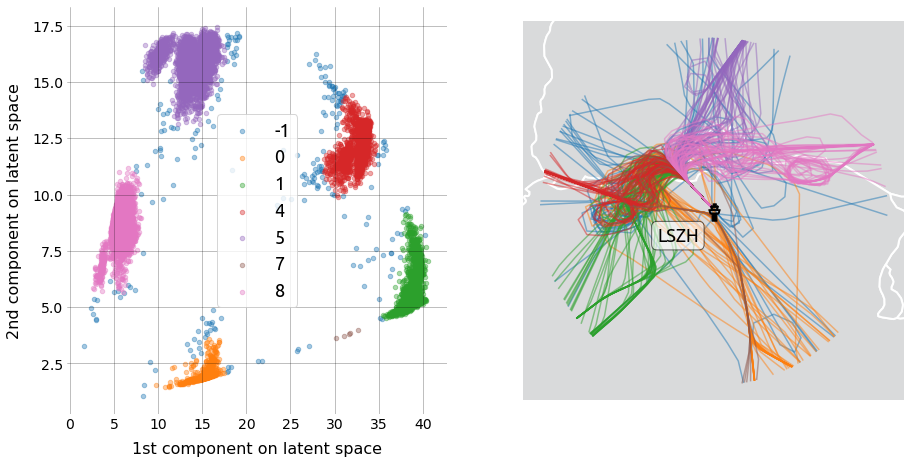

In [19]:
t_tsne = pretrained_clust(DBSCAN(eps=0.6, min_samples=30), "models/model.pth", "test/t_tsne_dbscan.pkl")
from artefact.plot import plot_latent_and_trajs
plot_latent_and_trajs(t_tsne, algo_clustering.get_latent(), "figs/latent_clusters_dbscan_06_30.png", plot_clusters=True, runway=14)

         flight_id
cluster           
0             4797
1             5239
2             4413
3             3132
4             1876


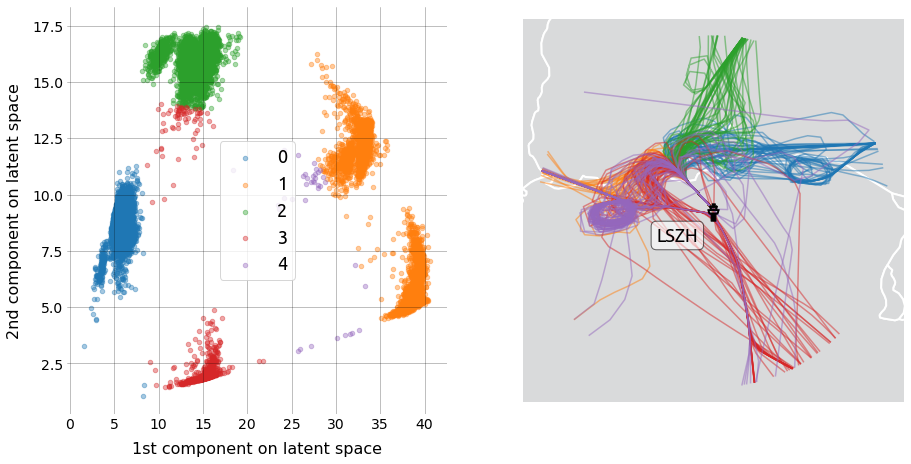

In [15]:
t_tsne = pretrained_clust(GaussianMixture(n_components=5), "models/model.pth", "test/t_tsne_gm.pkl")
from artefact.plot import plot_latent_and_trajs
plot_latent_and_trajs(t_tsne, algo_clustering.get_latent(), "figs/latent_clusters_gm.png", plot_clusters=True, runway=14)